# U net on roof labels

In [48]:
!pip install mycolorpy

  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3873 sha256=f4630a5225ed72014a8f7f75446ae7098ab4efebe9c469532637bdbf11570925
  Stored in directory: /root/.cache/pip/wheels/e6/a2/70/8113826487ef774503bcd38963b04b4c920deef45d7d54993e
Successfully built mycolorpy


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize

import keras.backend as K
import tensorflow as tf

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [81]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [82]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [83]:
y_train = redesign_y(y_train+1)
y_val = redesign_y(y_val+1)
y_test = redesign_y(y_test+1)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(100, 128, 128, 11)
(20, 128, 128, 11)
(50, 128, 128, 11)


## Show 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23 89 21 88 15]


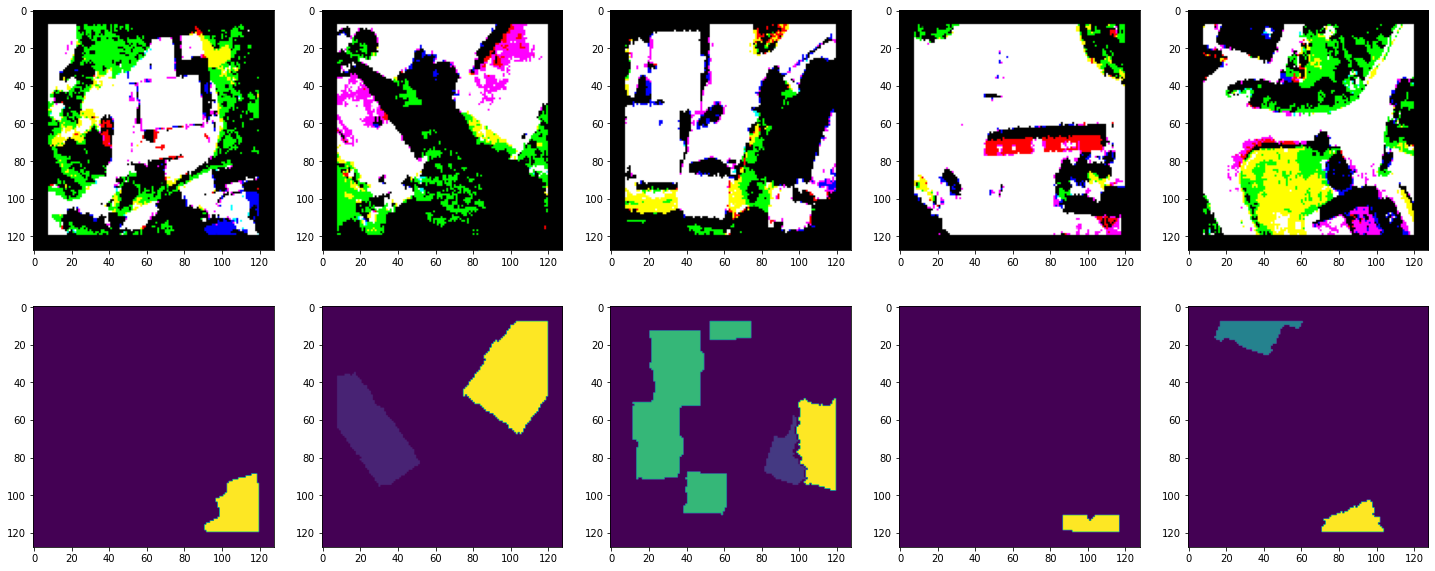

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (25,10))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21])))
    #ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(X_70_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(np.dstack((X_70_train[indx[i]][:,:,137],
    #                          X_70_train[indx[i]][:,:,194],
    #                          X_70_train[indx[i]][:,:,207])))
    ax[1,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

## Make U net

In [90]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=11, last_activation='softmax')

model.compile(optimizer='adam',
                         loss='categorical_crossentropy')

In [84]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_val -= mean
#X_train /= std

## Train model

In [91]:
h = model.fit(X_train,
              y_train, 
              validation_data=(X_val,y_val), 
              batch_size=16,
              epochs=150)

Epoch 1/150
7/7 [==============================] - 4s 303ms/step - loss: 3.0447 - val_loss: 1996.1553
Epoch 2/150
7/7 [==============================] - 1s 197ms/step - loss: 2.6031 - val_loss: 952.8436
Epoch 3/150
7/7 [==============================] - 1s 197ms/step - loss: 2.4026 - val_loss: 1672.0889
Epoch 4/150
7/7 [==============================] - 1s 196ms/step - loss: 2.2595 - val_loss: 6086.9502
Epoch 5/150
7/7 [==============================] - 1s 201ms/step - loss: 2.1368 - val_loss: 960.9584
Epoch 6/150
7/7 [==============================] - 1s 194ms/step - loss: 2.0665 - val_loss: 1009.8708
Epoch 7/150
7/7 [==============================] - 1s 193ms/step - loss: 2.0154 - val_loss: 9006.5459
Epoch 8/150
7/7 [==============================] - 1s 191ms/step - loss: 1.9550 - val_loss: 2449.5027
Epoch 9/150
7/7 [==============================] - 1s 198ms/step - loss: 1.8818 - val_loss: 207.8016
Epoch 10/150
7/7 [==============================] - 1s 194ms/step - loss: 1.8032 - va

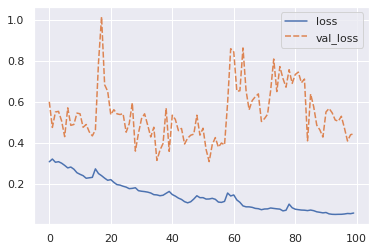

In [92]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['loss', 'val_loss']})

## Validate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


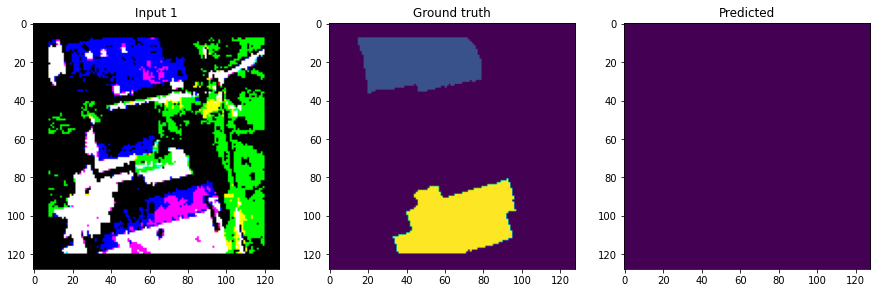

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


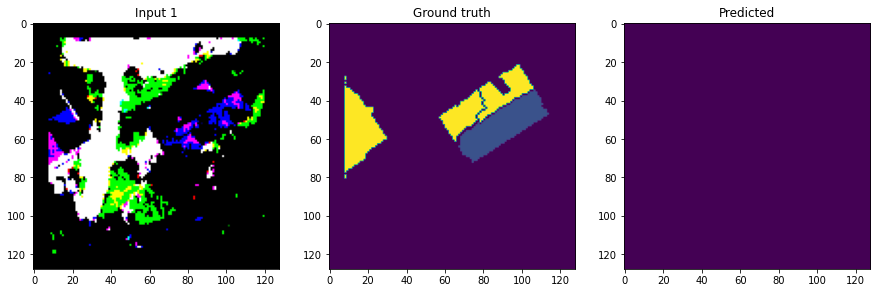

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


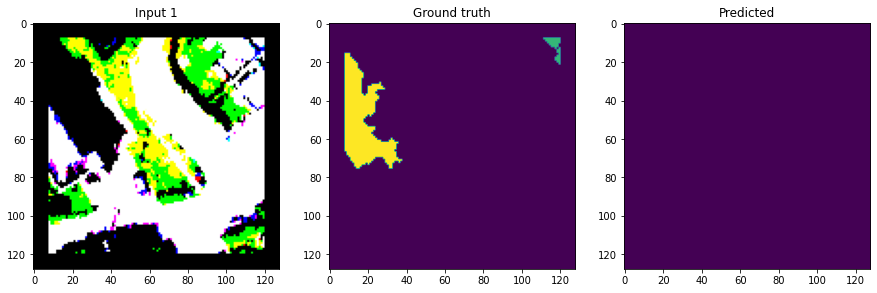

In [93]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21])))
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]/2500])[0].argmax(axis=2)
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

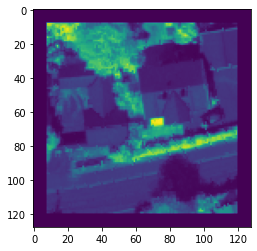

In [28]:
plt.imshow(X_train[3,:,:,150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


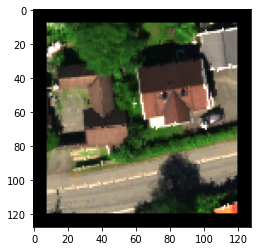

In [23]:
plt.imshow(np.dstack([X_train[3,:,:,76], X_train[3,:,:,46], X_train[3,:,:,21]])/2500)

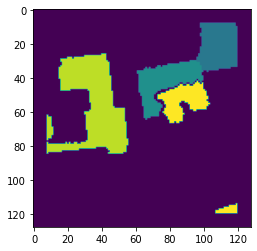

In [39]:
plt.imshow(y_train[3:4,:,:].argmax(axis=3)[0])


In [96]:
pred = model.predict(X_train[3:4]).argmax(axis=3)[0]

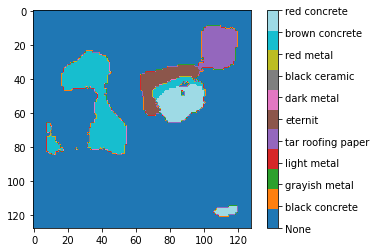

In [97]:
ticks = ["None"]
ticks.extend(['black concrete',
 'grayish metal',
 'light metal',
 'tar roofing paper',
 'eternit',
 'dark metal',
 'black ceramic',
 'red metal',
 'brown concrete',
 'red concrete'])

colors=mcp.gen_color(cmap="tab20",n=11)
colormap = ListedColormap(colors)

plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10])
cbar.ax.set_yticklabels(ticks)
plt.show()
